In [1]:
from SimPEG import *
import simpegDCIP as DC

Efficiency Warning: Interpolation will be slow, use setup.py!

            python setup.py build_ext --inplace
    


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [3]:
from numpy.polynomial import polynomial

In [4]:
cs = 0.5
mesh = Mesh.TensorMesh([np.ones(100)*cs, np.ones(50)*cs], "CN")
x = mesh.vectorCCx

In [5]:
problem.

SyntaxError: invalid syntax (<ipython-input-5-7373e6c9e935>, line 1)

In [6]:
actx = (x>-15.)&(x<15.)

In [7]:
order = 3
# c = np.r_[0,1,0.1,0.]
Vobs = polynomial.polyvander(x, order)
# dobs = V.dot(c)
# dobs1 = 1.2*np.sin(0.2*x)
# dobs2 = 1.2*np.sin(0.4*x)-4
# dobs = dobs1+dobs2
dobs = 0.2*x-6
# dobs = x*0.25
# dobs = Vobs.dot(c)
H = np.dot(Vobs.T, Vobs)
g = np.dot(Vobs.T, dobs)
mest = np.linalg.solve(H, g)

In [8]:
dpred = Vobs.dot(mest)

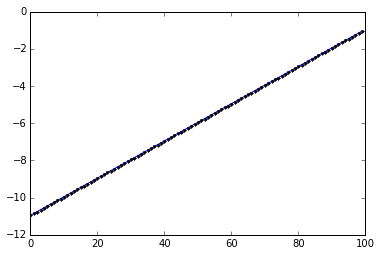

In [9]:
# plot(dobs1, 'k-')
# plot(dobs2, 'k.')
plot(dobs, 'b')
plot(dpred, 'k.')

In [10]:
V = polynomial.polyvander(x, order)

m1D = Mesh.TensorMesh([V.shape[1]+2])
weight = (1./(V**2).sum(axis=0))**0.5
weight = weight / weight.max()
weightmap = Maps.Weighting(m1D, weights=np.r_[1., 1., weight])
m0 = np.r_[np.log(1e-3), np.log(1e-3), np.r_[-3., np.zeros(V.shape[1]-1)] / weight]
mtrue = np.r_[np.log(1e-3), np.log(1e0), mest / weight]


In [11]:
polymap = Maps.PolyMap(mesh, V.shape[1]-1, logSigma=True, normal='Y')
mapping = polymap*weightmap

In [12]:
m1Dreg = Mesh.TensorMesh([V.shape[1]])

In [13]:
# mtrue = np.r_[np.log(1e-2), np.log(1e0), mest]
# m0 = np.r_[np.log(1e-2), np.log(1e0), np.r_[-3., np.zeros(V.shape[1]-1)]]

In [14]:
sigma = mapping*mtrue

In [15]:
# actind = (mesh.gridCC[:,0] > -15) & (mesh.gridCC[:,0] < 15)
# meshact = Mesh.TensorMesh([mesh.hx, mesh.hy], x0=mesh.x0)
# actmap = Maps.ActiveCells(mesh, actind, 2e-3)

In [16]:
xr = np.linspace(-15, 15, 20)
xz_A = Utils.ndgrid(xr, np.r_[-0.25])
xz_B = Utils.ndgrid(np.ones_like(xr)*22, np.r_[-0.25])
xz_M = Utils.ndgrid(xr, np.r_[-0.25])
xz_N = Utils.ndgrid(np.ones_like(xr)*-22, np.r_[-0.25])

ntx = xz_A.shape[0]
txList = []
for i in range(ntx):
    offset = abs(xz_A[i,0]-xz_M[:,0])
    actrx = offset > 5.
    rx = DC.RxDipole(xz_M[actrx,:], xz_N[actrx,:])
    src = DC.SrcDipole([rx], xz_A[i,:], xz_B[i,:])
    txList.append(src)

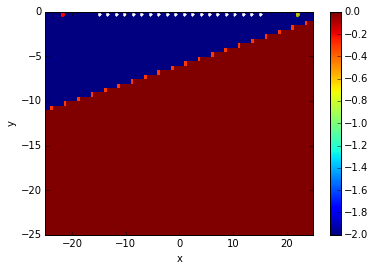

In [17]:
dat = mesh.plotImage(np.log10(sigma), clim=(-2, 0))
plt.colorbar(dat[0])
plot(xz_A[:,0], xz_A[:,1], 'w.')
plot(xz_B[:,0], xz_B[:,1], 'y.')
plot(xz_N[:,0], xz_N[:,1], 'r.')

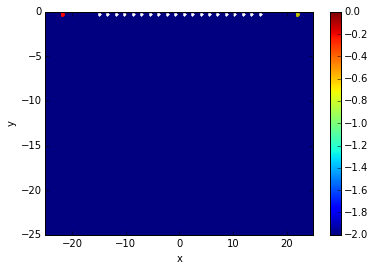

In [18]:
dat = mesh.plotImage(np.log10(mapping*m0), clim=(-2, 0))
plt.colorbar(dat[0])
plot(xz_A[:,0], xz_A[:,1], 'w.')
plot(xz_B[:,0], xz_B[:,1], 'y.')
plot(xz_N[:,0], xz_N[:,1], 'r.')

In [19]:
from pymatsolver import MumpsSolver

ImportError: No module named pymatsolver

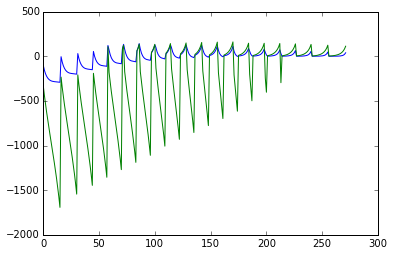

In [20]:
survey = DC.SurveyDC(txList)
problem = DC.ProblemDC_CC(mesh, mapping = mapping)
problem.pair(survey)
dtrue  = survey.dpred(mtrue)
d0  = survey.dpred(m0)
plot(dtrue)
plot(d0)

In [21]:
abs(dtrue).min()

0.0230637156236142

(array([  1.,   1.,   1.,   2.,   3.,   4.,   6.,   5.,   8.,  10.,  12.,
         14.,  15.,  19.,  30.,  28.,  32.,  37.,  22.,  22.]),
 array([-1.63707073, -1.43198266, -1.2268946 , -1.02180654, -0.81671847,
        -0.61163041, -0.40654234, -0.20145428,  0.00363378,  0.20872185,
         0.41380991,  0.61889797,  0.82398604,  1.0290741 ,  1.23416216,
         1.43925023,  1.64433829,  1.84942635,  2.05451442,  2.25960248,
         2.46469054]),
 <a list of 20 Patch objects>)

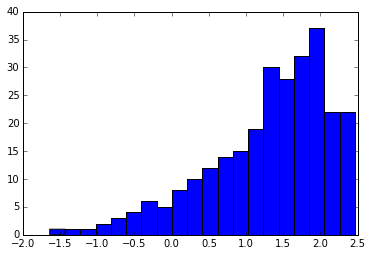

In [22]:
hist(np.log10(abs(dtrue)), bins = 20)

In [23]:
noise = 0.05*abs(dtrue)*np.random.randn(dtrue.shape[0])

In [29]:
survey.dobs = dtrue +noise
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.Wd = 1./(0.05*abs(dtrue)+ 0.1)
reg = Regularization.BaseRegularization(m1D)
opt = Optimization.InexactGaussNewton(maxIter=30,maxIterLS=20)
opt.remember('xc')
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
invProb.beta = 0.
betaSched = Directives.BetaSchedule(coolingFactor=1, coolingRate=1)
targetmis = Directives.TargetMisfit()
savemodel = Directives.SaveModelEveryIteration()
inv = Inversion.BaseInversion(invProb, directiveList=[betaSched,targetmis])
reg.mref = m0
mopt = inv.run(m0)

SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same solver as the problem***
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  0.00e+00  4.61e+07  0.00e+00  4.61e+07    8.24e+07      0              
   1  0.00e+00  5.79e+06  6.22e-01  5.79e+06    1.11e+07      0              
   2  0.00e+00  7.92e+05  2.32e+00  7.92e+05    1.50e+06      0   Skip BFGS  
   3  0.00e+00  1.38e+05  4.98e+00  1.38e+05    2.04e+05      0   Skip BFGS  
   4  0.00e+00  5.06e+04  8.55e+00  5.06e+04    2.94e+04      0   Skip BFGS  
   5  0.00e+00  3.82e+04  1.27e+01  3.82e+04    4.46e+03      0   Skip BFGS  
   6  0.00e+00  3.58e+04  1.59e+01  3.58e+04    1.56e+03      0   Skip BFGS  
   7  0.00e+00  3.20e+04  1.80e+01  3.20e+04    1.31e+04      0              
   8  0

In [342]:
survey.dobs = dtrue +noise
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.Wd = 1./(0.05*abs(dtrue)+ 0.1)
reg = Regularization.BaseRegularization(m1D)
opt = Optimization.InexactGaussNewton(maxIter=30,maxIterLS=20)
opt.remember('xc')
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
invProb.beta = 0.
betaSched = Directives.BetaSchedule(coolingFactor=1, coolingRate=1)
targetmis = Directives.TargetMisfit()
savemodel = Directives.SaveModelEveryIteration()
inv = Inversion.BaseInversion(invProb, directiveList=[betaSched,targetmis])
reg.mref = m0
mopt = inv.run(mopt.copy())

SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same solver as the problem***
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  0.00e+00  2.96e+03  2.08e+01  2.96e+03    6.91e+03      0              
   1  0.00e+00  1.63e+03  2.26e+01  1.63e+03    1.11e+04      0              
   2  0.00e+00  1.09e+03  2.39e+01  1.09e+03    3.34e+03      0   Skip BFGS  
   3  0.00e+00  7.29e+02  2.48e+01  7.29e+02    7.49e+03      1   Skip BFGS  
   4  0.00e+00  6.44e+02  2.50e+01  6.44e+02    2.56e+03      1              
   5  0.00e+00  5.17e+02  3.00e+01  5.17e+02    6.28e+03      0              
   6  0.00e+00  4.22e+02  2.85e+01  4.22e+02    1.37e+03      0              
   7  0.00e+00  3.96e+02  2.75e+01  3.96e+02    3.19e+03      3   Skip BFGS  
   8  0

In [262]:
survey.dobs = dtrue +noise
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.Wd = 1./(0.05*abs(dtrue)+ 0.1)
reg = Regularization.BaseRegularization(m1D)
opt = Optimization.InexactGaussNewton(maxIter=30,maxIterLS=20)
opt.remember('xc')
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
invProb.beta = 0.
betaSched = Directives.BetaSchedule(coolingFactor=1, coolingRate=1)
targetmis = Directives.TargetMisfit()
savemodel = Directives.SaveModelEveryIteration()
inv = Inversion.BaseInversion(invProb, directiveList=[betaSched,targetmis])
reg.mref = m0
mopt = inv.run(mopt.copy())

SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same solver as the problem***
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  0.00e+00  4.32e+03  7.43e+02  4.32e+03    1.08e+04      0              
   1  0.00e+00  4.29e+03  7.43e+02  4.29e+03    3.09e+04      3              
   2  0.00e+00  4.00e+03  7.43e+02  4.00e+03    1.36e+04      0              
   3  0.00e+00  3.84e+03  7.42e+02  3.84e+03    2.61e+04      2   Skip BFGS  
   4  0.00e+00  3.78e+03  7.42e+02  3.78e+03    7.52e+03      1   Skip BFGS  
   5  0.00e+00  3.72e+03  7.42e+02  3.72e+03    8.63e+03      3              
   6  0.00e+00  3.72e+03  7.42e+02  3.72e+03    1.06e+04      9   Skip BFGS  
   7  0.00e+00  3.67e+03  7.42e+02  3.67e+03    5.05e+03      1              
   8  0

In [266]:
survey.dobs = dtrue +noise
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.Wd = 1./(0.05*abs(dtrue)+ 0.1)
reg = Regularization.BaseRegularization(m1D)
opt = Optimization.InexactGaussNewton(maxIter=30,maxIterLS=20)
opt.remember('xc')
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
invProb.beta = 0.
betaSched = Directives.BetaSchedule(coolingFactor=1, coolingRate=1)
targetmis = Directives.TargetMisfit()
savemodel = Directives.SaveModelEveryIteration()
inv = Inversion.BaseInversion(invProb, directiveList=[betaSched,targetmis])
reg.mref = m0
mopt = inv.run(mopt.copy())

SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same solver as the problem***
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  0.00e+00  2.03e+03  7.53e+02  2.03e+03    9.31e+03      0              
   1  0.00e+00  2.03e+03  7.53e+02  2.03e+03    7.87e+03      4              
   2  0.00e+00  1.59e+03  7.54e+02  1.59e+03    1.27e+04      1              
   3  0.00e+00  1.48e+03  7.54e+02  1.48e+03    7.41e+03      1              
   4  0.00e+00  1.46e+03  7.54e+02  1.46e+03    9.53e+03      4              
   5  0.00e+00  1.44e+03  7.56e+02  1.44e+03    8.32e+03      0              
   6  0.00e+00  1.40e+03  7.57e+02  1.40e+03    8.97e+03      3              
   7  0.00e+00  1.34e+03  7.55e+02  1.34e+03    7.52e+03      0              
   8  0

In [271]:
survey.dobs = dtrue +noise
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.Wd = 1./(0.05*abs(dtrue)+ 0.1)
reg = Regularization.BaseRegularization(m1D)
opt = Optimization.InexactGaussNewton(maxIter=30,maxIterLS=20)
opt.remember('xc')
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
invProb.beta = 0.
betaSched = Directives.BetaSchedule(coolingFactor=1, coolingRate=1)
targetmis = Directives.TargetMisfit()
savemodel = Directives.SaveModelEveryIteration()
inv = Inversion.BaseInversion(invProb, directiveList=[betaSched,targetmis])
reg.mref = m0
mopt = inv.run(mopt.copy())

SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same solver as the problem***
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  0.00e+00  1.04e+03  7.65e+02  1.04e+03    4.56e+03      0              
   1  0.00e+00  1.03e+03  7.65e+02  1.03e+03    1.04e+05      4              
   2  0.00e+00  1.01e+03  7.65e+02  1.01e+03    3.70e+04      0              
   3  0.00e+00  1.01e+03  7.65e+02  1.01e+03    2.21e+04      1              
   4  0.00e+00  9.94e+02  7.66e+02  9.94e+02    9.14e+03      0              
   5  0.00e+00  9.93e+02  7.66e+02  9.93e+02    1.55e+04      6              
   6  0.00e+00  9.93e+02  7.66e+02  9.93e+02    1.22e+04      2              
   7  0.00e+00  9.93e+02  7.66e+02  9.93e+02    8.68e+03      1              
   8  0

In [346]:
XC = opt.recall('xc')

In [347]:
from ipywidgets import interact, IntSlider
def viewInv(iteration):
    fig  = plt.figure(num=0,figsize = (10,5))
    ax = plt.subplot(111)
    dat = mesh.plotImage(np.log10(mapping*XC[iteration]), grid=True, ax=ax, clim=(-3, 0), gridOpts={'alpha':0.2}, pcolorOpts={'cmap':cm.RdPu})
#     ax.set_xlim(mesh.vectorNx.min(), mesh.vectorNx.max())
#     ax.set_ylim(mesh.vectorNy.min(), mesh.vectorNy.max())
    ax.plot(mesh.vectorCCx, dpred, 'r--')
    ax.plot(xz_A[:,0], xz_A[:,1], 'k.')
    ax.plot(xz_B[:,0], xz_B[:,1], 'r.')
    ax.plot(xz_N[:,0], xz_N[:,1], 'b.')    
#     plt.colorbar(dat[0], ax=ax)
#     ax.set_ylim (-15, 0.)
#     ax.set_xlim (-15, 15.)
    plt.show()
    return True

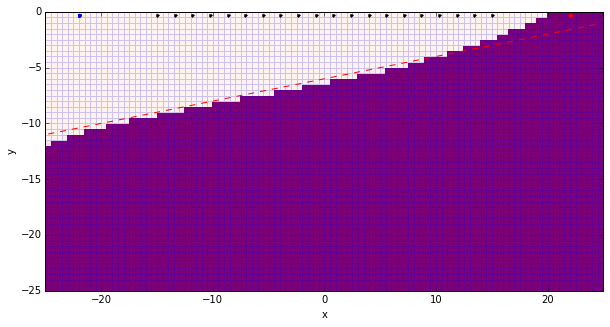

True

In [348]:
interact(viewInv, iteration = IntSlider(min=0, max=opt.iter-1,step=1, value=0))

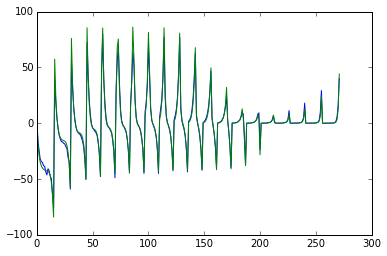

In [270]:
plt.plot(survey.dobs)
plt.plot(invProb.dpred)